In [43]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [45]:
fname = "precalculated_arrays.pkl"

In [ ]:
# desc = "H_X_red, H_B_red, H_laser_z, H_laser_x, C_array, C_conj_array, rho_ini, ME_main, Gamma"
# with open(fname, 'wb') as f:
#     pickle.dump([desc, H_X_red, H_B_red, H_laser_z, H_laser_x, C_array, C_conj_array, rho_ini, ME_main, Gamma], f)

In [51]:
with open(fname, 'rb') as f:
    desc, H_X_red, H_B_red, H_laser_z, H_laser_x, C_array, C_conj_array, rho_ini, ME_main, Gamma = pickle.load(f)

In [63]:
Cprecalc = np.einsum('ijk,ikl', C_conj_array, C_array)

In [64]:
_H = np.zeros([39,39], dtype = 'complex')
_H[:36, :36] = H_X_shifted
_H[36:,36:] = H_B_shifted

In [65]:
Cprecalc = np.einsum('ijk,ikl', C_conj_array, C_array)

## Julia

In [66]:
from julia import Main

In [67]:
Main.eval("""using Waveforms""")
Main.eval("""using DifferentialEquations""")
Main.eval("""using StaticArrays""")
Main.eval("""using LinearAlgebra""")
Main.eval("""using CuArrays""")

In [235]:
Omega = 4.5*Gamma*np.abs(ME_main)
wp = Gamma/(2*np.pi)

In [236]:
1/(Omega/(2*2*np.pi*np.abs(ME_main)))

2.7925268031909277e-07

In [237]:
1/wp

6.283185307179586e-07

In [238]:
Main.C_array = C_array
Main.C_conj_array = C_conj_array
Main.H_laser_z = H_laser_z
Main.H_laser_x = H_laser_x
Main.ME_main = ME_main
Main.Omega = Omega
Main.wp = wp
Main.Cprecalc = Cprecalc
Main.rho_ini = rho_ini
Main.Hprecalc = _H

In [239]:
Main.eval("""
const rho_ini_const_GPU = CuArray(rho_ini)
const H_laser_z_const_GPU = CuArray(H_laser_z)
const H_laser_x_const_GPU = CuArray(H_laser_x)
const Cprecalc_const_GPU = CuArray(Cprecalc)
const Hprecalc_const_GPU = CuArray(Hprecalc)
const C_array_const_GPU = CuArray(C_array)
const C_conj_array_const_GPU = CuArray(C_conj_array)
const wp_const = wp
const ME_main_const = ME_main
const Omega_const = Omega
""")

17750097.622024998

In [242]:
Main.eval("z = similar(H_laser_z_const_GPU)");

JuliaError: Exception 'scalar getindex is disallowed' occurred while calling julia code:
convert(PyCall.PyObject, z = similar(H_laser_z_const_GPU))

In [244]:
Main.eval("typeof(z)")

<PyCall.jlwrap CuArray{Complex{Float64},2,Nothing}>

In [245]:
Main.eval("CuArrays.allowscalar(false)")

In [246]:
%%timeit
Main.eval("""
z .= H_laser_z_const_GPU*rho_ini_const_GPU
tmp = 0
""")

230 µs ± 3.96 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [247]:
Main.eval("""
function sum_mult!(result, A, B, C, idx_max)
    intermediate1 = similar(result)
    intermediate2 = similar(result)
    @inbounds for i = 1:idx_max
        mul!(intermediate1,B,C[i,:,:])
        mul!(intermediate2, A[i,:,:], intermediate1)
        result .+= intermediate2
    end
end
""")

<PyCall.jlwrap sum_mult!>

In [248]:
Main.eval("""
fill!(z,0)
tmp = 0
""")

0

In [249]:
%time
Main.eval("sum_mult!(z,C_array_const_GPU, rho_ini_const_GPU, C_conj_array_const_GPU, 33)")

Wall time: 0 ns


In [250]:
%%timeit
Main.eval("sum_mult!(z,C_array_const_GPU, rho_ini_const_GPU, C_conj_array_const_GPU, 33)")

3.72 ms ± 17.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [251]:
Main.eval("""
function square_wave(t, frequency, phase)
    0.5.*(1 .+ squarewave(2*pi.*frequency.*t .+ phase))
end
""")

<PyCall.jlwrap square_wave>

In [252]:
Main.eval("""
function H_oc_t(t, Omega, wp)
    (Omega./ME_main_const)./2 .* (H_laser_z_const_GPU.*square_wave(t,wp,0.0) .+ H_laser_x_const_GPU.*square_wave(t,wp,3.141592653589793))
end
""")

<PyCall.jlwrap H_oc_t>

In [253]:
Main.eval("""
function Hamiltonian(t, Omega, wp)
    Hprecalc_const_GPU .+ H_oc_t(t,Omega, wp)
end
""")

<PyCall.jlwrap Hamiltonian>

In [254]:
Main.eval("""
function Lindblad_rhs!(du, u, p, t)
    @inbounds begin
        Omega = p[1]
        wp = p[2]

        intermediate = similar(u)
        fill!(du,0.0)
        sum_mult!(du,C_array_const_GPU,u,C_conj_array_const_GPU,33)
        Ham = Hamiltonian(t, Omega, wp)
        mul!(intermediate, Ham, u)
        du .-= 1im .* intermediate
        mul!(intermediate, u, Ham)
        du .+= 1im .* intermediate
        mul!(intermediate, Cprecalc_const_GPU, u)
        du .-= 0.5 .* intermediate
        mul!(intermediate, u, Cprecalc_const_GPU)
        du .-= 0.5 .* intermediate
    end
    nothing
end
""")

<PyCall.jlwrap Lindblad_rhs!>

In [255]:
Main.eval("p = [Omega, wp]")

array([17750097.622025  ,  1591549.43091895])

In [256]:
%%time
Main.eval("""
tspan = (0.0f0, 100e-6)
prob = ODEProblem(Lindblad_rhs!,rho_ini_const_GPU,tspan,p)
tmp = 0
""")

Wall time: 0 ns


0

In [257]:
%%time
Main.eval("""
sol = solve(prob, Tsit5(), saveat = 5e-8)
tmp = 0
""")

Wall time: 29.1 s


0

3.3213728523421633


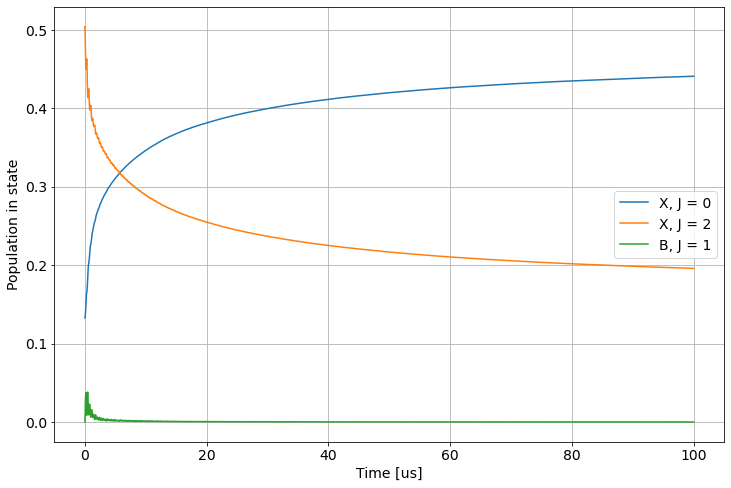

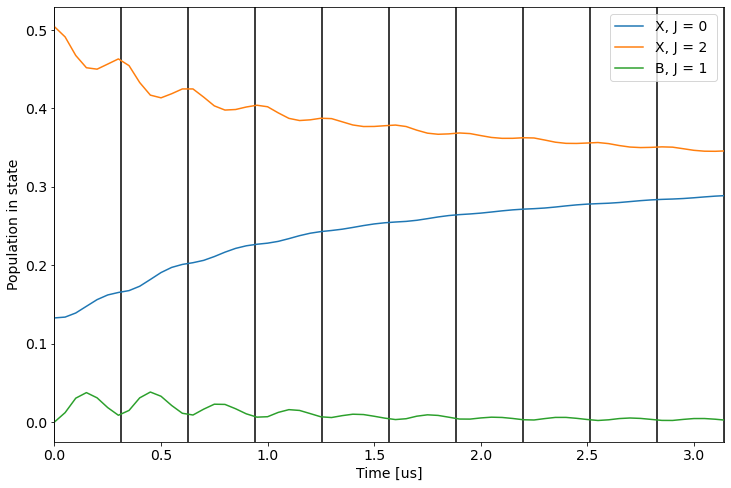

In [258]:
Main.eval("CuArrays.allowscalar(true)")
ut = np.array(Main.eval("sol.u")).T
Main.eval("CuArrays.allowscalar(false)")
pop_results = np.real(np.einsum('jji->ji',ut.reshape((rho_ini.shape[0], rho_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("""sol.t""")

m = t_array <= 300e-6

t_array = t_array[m]
pop_results = pop_results[:,m]

#Plot populations in different J
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
PB1 = np.sum(pop_results[36:,:], axis = 0)

fig, ax = plt.subplots(figsize = (12,8))
# ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
# ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
# ax.plot(t_array*1e6, P1, label = 'X, J = 1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)

fig, ax = plt.subplots(figsize = (12,8))
# ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
# ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1 ')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlim(0,5e6/wp)
for i in range(20):
    ax.axvline(i*1e6/wp/2, zorder = 0, color = 'k')
    
print(P0[-1]/P0[0])

In [278]:
Main.eval("using DiffEqGPU ")
Main.eval("using CUDA")

In [220]:
Main.eval("const Omegas = (Omega/4.5)*(0.5:0.25:4.5)")

[1095685.0383966048,
 1643527.5575949072,
 2191370.0767932096,
 2739212.595991512,
 3287055.1151898145,
 3834897.634388117,
 4382740.153586419,
 4930582.6727847215,
 5478425.191983024,
 6026267.711181327,
 6574110.230379629,
 7121952.749577931,
 7669795.268776234,
 8217637.787974536,
 8765480.307172839,
 9313322.82637114,
 9861165.345569443]

In [281]:
Main.eval("""
const intermediate_GPU = similar(rho_ini_const_GPU)
const intermediate1_GPU = similar(rho_ini_const_GPU)
const intermediate2_GPU = similar(rho_ini_const_GPU)
""")

JuliaError: Exception 'scalar getindex is disallowed' occurred while calling julia code:
convert(PyCall.PyObject, 
const intermediate_GPU = similar(rho_ini_const_GPU)
const intermediate1_GPU = similar(rho_ini_const_GPU)
const intermediate2_GPU = similar(rho_ini_const_GPU)
)

In [292]:
Main.eval("""
function Lindblad_rhs!(du, u, p, t)
    @inbounds begin
        Omega = p[1]
        wp = p[2]

        for i = 1:idx_max
            mul!(intermediate1_GPU,B,C[i,:,:])
            mul!(intermediate2_GPU, A[i,:,:], intermediate1_GPU)
            result .+= intermediate2_GPU
        end
        
        Ham = Hprecalc_const_GPU
        Ham .+= (Omega./ME_main_const)./2 .* (H_laser_z_const_GPU.*(0.5.*(1 .+ squarewave(2*pi.*frequency.*t .+ 0)))) 
        Ham .+= (Omega./ME_main_const)./2 .* (H_laser_x_const_GPU.*(0.5.*(1 .+ squarewave(2*pi.*frequency.*t .+ 3.141592653589793))))
        
        mul!(intermediate_GPU, Ham, u)
        du -= 1im * intermediate_GPU
        mul!(intermediate_GPU, u, Ham)
        du += 1im * intermediate_GPU
        mul!(intermediate_GPU, Cprecalc_const_GPU, u)
        du -= 0.5 .* intermediate_GPU
        mul!(intermediate_GPU, u, Cprecalc_const_GPU)
        du -= 0.5 .* intermediate_GPU
    end
    nothing
end
""")

<PyCall.jlwrap Lindblad_rhs!>

In [293]:
Main.eval("""
tspan = (0.0f0, 100e-6)
prob = ODEProblem(Lindblad_rhs!,rho_ini,tspan,p)
tmp = 0
""")

0

In [294]:
Main.eval("""
function prob_func(prob,i,repeat)
    remake(prob,p=[Omegas[i],wp])
end
""")

<PyCall.jlwrap prob_func>

In [295]:
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, safetycopy = false)
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [297]:
%%time
Main.eval("CuArrays.allowscalar(true)")
Main.eval("""
sol = solve(ens_prob,Tsit5(),EnsembleGPUArray(),trajectories=4)
tmp = 0
""")
Main.eval("CuArrays.allowscalar(False)")

JuliaError: Exception 'GPU compilation of gpu_kernel(Cassette.Context{nametype(Ctx),Nothing,Nothing,GPUifyLoops.var"##PassType#253",Nothing,Cassette.DisableHooks}, typeof(DiffEqGPU.gpu_kernel), typeof(Lindblad_rhs!), CUDAnative.CuDeviceArray{Complex{Float64},2,CUDAnative.AS.Global}, CUDAnative.CuDeviceArray{Complex{Float64},2,CUDAnative.AS.Global}, CUDAnative.CuDeviceArray{Float64,2,CUDAnative.AS.Global}, Float64) failed
KernelError: recursion is currently not supported

Try inspecting the generated code with any of the @device_code_... macros.

Stacktrace:
 [1] _nextind_str at strings/string.jl:141
 [2] nextind at strings/string.jl:137
 [3] _nextind_str at strings/string.jl:141
 [4] current_logger_for_env at logging.jl:386
 [5] #673 at C:\Users\ogras\.julia\packages\CUDAdrv\Uc14X\src\CUDAdrv.jl:64
 [6] lock at lock.jl:159
 [7] _functional at C:\Users\ogras\.julia\packages\CUDAdrv\Uc14X\src\CUDAdrv.jl:63
 [8] functional at C:\Users\ogras\.julia\packages\CUDAdrv\Uc14X\src\CUDAdrv.jl:55
 [9] #615#cache_fptr! at C:\Users\ogras\.julia\packages\CUDAapi\XuSHC\src\call.jl:31
 [10] initialize_thread at C:\Users\ogras\.julia\packages\CUDAnative\ierw8\src\init.jl:51
 [11] gpu_kernel at C:\Users\ogras\.julia\packages\DiffEqGPU\senL8\src\DiffEqGPU.jl:8' occurred while calling julia code:

sol = solve(ens_prob,Tsit5(),EnsembleGPUArray(),trajectories=4)
tmp = 0
